# Marcos Gurruchaga - TP Individual Machine Learning - Curso K5551

## Descripción del Trabajo

Este trabajo implementa un pipeline completo de Machine Learning para la construcción de una **Analytic Base Table (ABT)** a partir de datos bancarios. El objetivo es preparar un dataset con features de identidad, transformadas y agregadas para entrenar un modelo predictivo.

### Casos de Uso Implementados
0. **Importación de Librerías e Investigación del CSV inicial** - Investigar el contenido del dataset e importar librerías
1. **Filtrado de clientes con 9 meses de datos** - Garantizar consistencia temporal
2. **Filtrado sin paquete activo y sin CoBranding** - Segmentación específica (Enero 2019)
3. **Definición de ventanas temporales** - Prediction (Mar-Abr 2019), Lead (Feb 2019), Historical (Ago 2018-Ene 2019)
4. **Análisis de balance del target** - Evaluación de distribución de clases
5. **Técnicas de balanceo de datos** - Métodos 50/50 (no aplicados al dataset final)
6. **Clasificación de tipos de datos** - Texto, numérico, categórico y fechas
7. **Creación de Identity y Transform Features** - Variables de identidad y transformadas
8. **Detección y tratamiento de valores faltantes** - Completar valores faltantes con lógica de negocio
9. **Análisis de outliers en SavingAccount_Balance_Average** - Boxplots, skewness y conclusiones
10. **Metodología de outliers aplicada a otras features** - Winsorización y regla 3-sigma
11. **Creación de Aggregate Features** - Estadísticas por ventanas temporales (últimos 6, 3 meses, etc.)
12. **Construcción de la Analytic Base Table** - Integración final de todas las features

**Resultado:** ABT con 23,191 clientes únicos lista para entrenamiento de modelos.

### Notas

- El CSV original contenía una línea con "(238615 rows affected)" que se ignoró por no ser un dato válido

## Caso de Uso 0: Importación de Librerías e Investigación del CSV inicial

In [202]:
# Importación de librerías necesarias para el análisis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Configuración de visualización para mejor lectura de datos
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
sns.set_style('whitegrid')

In [203]:
# Lectura del archivo de datos con separador pipe (|) y client_id como string
data = pd.read_csv('data.csv', sep='|', dtype={'client_id': str})

# Verificar dimensiones del dataset
print(f'Dimensiones del dataset: {data.shape}')
print(f'Columnas: {data.shape[1]}, Filas: {data.shape[0]}')

Dimensiones del dataset: (238616, 77)
Columnas: 77, Filas: 238616


In [204]:
# Exploración inicial: primeras filas del dataset
data.head()

,client_id,Target,Month,First_product_dt,Last_product_dt,CreditCard_Premium,CreditCard_Active,CreditCard_CoBranding,Loan_Active,Mortgage_Active,SavingAccount_Active_ARG_Salary,SavingAccount_Active_ARG,SavingAccount_Active_DOLLAR,DebitCard_Active,Investment_Active,Package_Active,Insurance_Life,Insurance_Home,Insurance_Accidents,Insurance_Mobile,Insurance_ATM,Insurance_Unemployment,Sex,Client_Age_grp,SavingAccount_Balance_FirstDate,SavingAccount_Balance_LastDate,SavingAccount_Balance_Average,SavingAccount_Days_with_use,SavingAccount_Days_with_Credits,SavingAccount_Days_with_Debits,SavingAccount_Salary_Payment_Transactions,SavingAccount_Transfer_In_Transactions,SavingAccount_ATM_Extraction_Transactions,SavingAccount_Service_Payment_Transactions,SavingAccount_CreditCard_Payment_Transactions,SavingAccount_Transfer_Out_Transactions,SavingAccount_DebitCard_Spend_Transactions,SavingAccount_Transactions_Transactions,SavingAccount_Credits_Transactions,SavingAccount_Debits_Transactions,SavingAccount_Salary_Payment_Amount,SavingAccount_Transfer_In_Amount,SavingAccount_ATM_Extraction_Amount,SavingAccount_Service_Payment_Amount,SavingAccount_CreditCard_Payment_Amount,SavingAccount_Transfer_Out_Amount,SavingAccount_DebitCard_Spend_Amount,SavingAccount_Total_Amount,SavingAccount_Credits_Amounts,SavingAccount_Debits_Amounts,Operations_Bank,Operations_Terminal,Operations_HomeBanking,Operations_Mobile,Operations_Ivr,Operations_Telemarketer,Operations_ATM,CreditCard_Balance_ARG,CreditCard_Balance_DOLLAR,CreditCard_Total_Limit,CreditCard_Total_Spending,CreditCard_Spending_1_Installment,CreditCard_Spending_Installments,CreditCard_Spending_CrossBoarder,CreditCard_Spending_Aut_Debits,CreditCard_Revolving,CreditCard_Payment_Aut_Debit,CreditCard_Payment_External,CreditCard_Payment_Cash,CreditCard_Payment_Web,CreditCard_Payment_ATM,CreditCard_Payment_TAS,Investment_Numbers,Mobile,Email,Region,CreditCard_Product
0,5856970,1.0,2018-10-01,2013-10-23,2019-01-10,No,Yes,No,No,No,No,Yes,Yes,Yes,Yes,No,No,No,No,No,No,No,F,Mayor a 70 años,1.33,79.39,406.35,7.0,6.0,6.0,0.0,0.0,2.0,0.0,1.0,0.0,1.0,17.0,7.0,10.0,0.0,0.0,4500.0,0.0,9823.39,0.0,975.0,311225.28,155651.67,155573.61,0.0,2.0,1.0,0.0,1.0,0.0,1.0,9823.39,0.0,64000.0,8021.05,1710.91,5650.47,0.0,659.67,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,Yes,Yes,NaN,NaN
1,6371753,0.0,2018-09-01,2015-07-29,2018-06-02,No,No,No,No,No,No,Yes,Yes,Yes,No,No,No,No,No,No,No,No,F,Entre 50 y 59 años,198.82,57.27,73.56,2.0,1.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,3.0,0.0,3700.0,0.0,0.0,0.00,0.0,0.0,7541.55,3700.00,3841.55,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Yes,No,NaN,NaN
2,5928737,0.0,2019-01-01,2016-08-31,2018-12-27,No,No,No,No,No,No,Yes,Yes,Yes,No,No,No,No,No,No,No,No,M,Entre 30 y 39 años,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Yes,Yes,NaN,NaN
3,475064,0.0,2018-12-01,2014-07-13,2017-11-30,No,Yes,No,No,No,No,Yes,No,Yes,No,No,No,Yes,No,No,No,No,F,Mayor a 70 años,1370.90,1506.67,2366.02,3.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,2.0,1.0,0.0,0.0,0.0,0.0,3864.37,0.0,0.0,7864.51,4000.14,3864.37,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2585.28,0.0,112000.0,2418.48,0.00,2056.47,0.0,362.01,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,Yes,Yes,NaN,NaN
4,3615172,0.0,2018-09-01,2017-12-27,2017-12-28,No,No,No,No,No,No,Yes,No,Yes,No,No,No,No,No,No,No,No,M,Entre 40 y 49 años,0.40,0.40,0.40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Yes,No,NaN,NaN


In [205]:
# Verificar la distribución de datos por mes
data['Month'].value_counts().sort_index()

Month
2018-08-01    26502
2018-09-01    26501
2018-10-01    26501
2018-11-01    26501
2018-12-01    26501
2019-01-01    26503
2019-02-01    26512
2019-03-01    26547
2019-04-01    26547
Name: count, dtype: int64

## Caso de Uso 1: Tomar solo clientes con 9 meses de datos



**Resolución:** Agrupamos por client_id y contamos los meses únicos. Filtramos solo aquellos clientes que tienen exactamente 9 registros mensuales.

In [206]:
# Contar cantidad de meses por cliente
clientes_meses = data.groupby('client_id')['Month'].count().reset_index()
clientes_meses.columns = ['client_id', 'cant_meses']

# Verificar distribución de cantidad de meses
print('Distribución de cantidad de meses por cliente:')
print(clientes_meses['cant_meses'].value_counts().sort_index())

# Filtrar clientes con exactamente 9 meses de datos
clientes_9meses = clientes_meses[clientes_meses['cant_meses'] == 9][['client_id']]
print(f'\nClientes con 9 meses de datos: {len(clientes_9meses)}')

# Aplicar filtro al dataset principal
data = data.merge(clientes_9meses, on='client_id', how='inner')
print(f'Registros después del filtro: {len(data)}')

Distribución de cantidad de meses por cliente:
cant_meses
0        1
1        6
2       38
3        9
4        6
7        9
8        9
9    26483
Name: count, dtype: int64

Clientes con 9 meses de datos: 26483
Registros después del filtro: 238347


## Caso de Uso 2: Tomar solo clientes sin paquete activo y sin CoBranding

**Resolución:** Filtramos clientes sin Package_Active='Yes' y sin CreditCard_CoBranding='Yes' en enero 2019. Tomamos ese mes específicamente porque es el último mes antes de las ventanas de predicción (febrero-marzo 2019), entonces necesitamos verificar el estado del cliente en el momento previo a predecir.

In [207]:
# Verificar distribución de Package_Active
print('Distribución de Package_Active:')
print(data['Package_Active'].value_counts())

Distribución de Package_Active:
Package_Active
No     233914
Yes      4433
Name: count, dtype: int64


In [208]:
# Filtrar clientes sin paquete activo y sin CoBranding en enero 2019 (Lead Window)
# Usamos enero 2019 porque es el mes previo a la ventana de predicción
clientes_sinPaquete = data[(data['Package_Active'] == 'No') & 
                           (data['Month'] == '2019-01-01')][['client_id']]

print(f'Clientes sin paquete activo en enero 2019: {len(clientes_sinPaquete)}')

# Filtrar clientes sin CoBranding en enero 2019
clientes_sinCoBranding = data[(data['CreditCard_CoBranding'] == 'No') & 
                              (data['Month'] == '2019-01-01')][['client_id']]

print(f'Clientes sin CoBranding en enero 2019: {len(clientes_sinCoBranding)}')

# Aplicar ambos filtros al dataset (inner join para intersección)
data = data.merge(clientes_sinPaquete, on='client_id', how='inner')
data = data.merge(clientes_sinCoBranding, on='client_id', how='inner')

print(f'\nRegistros después de ambos filtros: {len(data)}')
print(f'Clientes únicos: {data["client_id"].nunique()}')

Clientes sin paquete activo en enero 2019: 26006
Clientes sin CoBranding en enero 2019: 23646

Registros después de ambos filtros: 208719
Clientes únicos: 23191


## Caso de Uso 3: Definición de Ventanas de Tiempo



**Prediction Window:** Últimos 2 meses (marzo-abril 2019) - Período donde queremos predecir el target  

**Lead Window:** 1 mes (febrero 2019) - Período de transición/separación  

**Historical/Training Window:** Resto de meses (agosto 2018 - enero 2019) - Datos históricos para crear features

In [209]:
# PREDICTION WINDOW: Crear variable target desde los últimos 2 meses (marzo-abril 2019)
# Si el cliente tiene Target=1 en alguno de esos meses, consideramos que compró el paquete
data_TGT = data[(data['Month'].isin(['2019-03-01', '2019-04-01'])) & 
                (data['Target'] == 1)][['client_id']].drop_duplicates()
data_TGT['TGT'] = 1

print(f'Clientes con target=1 en ventana de predicción: {len(data_TGT)}')

Clientes con target=1 en ventana de predicción: 6823


In [210]:
# HISTORICAL/TRAINING WINDOW: Filtrar datos históricos para crear features

# Usamos desde agosto 2018 hasta enero 2019 (6 meses)

data_trainWindow = data[data['Month'].isin(['2018-08-01', 

                                             '2018-09-01', 

                                             '2018-10-01', 

                                             '2018-11-01', 

                                             '2018-12-01', 

                                             '2019-01-01'])].copy()



print(f'Registros en ventana de entrenamiento: {len(data_trainWindow)}')

print(f'Clientes únicos: {data_trainWindow["client_id"].nunique()}')

print(f'\nDistribución por mes:')

print(data_trainWindow['Month'].value_counts().sort_index())

Registros en ventana de entrenamiento: 139146
Clientes únicos: 23191

Distribución por mes:
Month
2018-08-01    23191
2018-09-01    23191
2018-10-01    23191
2018-11-01    23191
2018-12-01    23191
2019-01-01    23191
Name: count, dtype: int64


In [211]:
# Crear dataframe base con clientes únicos para construir la tabla analítica
data_final = data_trainWindow[data_trainWindow['Month'] == '2019-01-01'][['client_id']]

# Unir con el target usando left join para mantener todos los clientes
# Los clientes sin target tendrán TGT=0
data_final = data_final.merge(data_TGT, how='left', on='client_id')
data_final['TGT'] = data_final['TGT'].fillna(0)

print(f'Clientes en base final: {len(data_final)}')
print(f'\nDistribución del target:')
print(data_final['TGT'].value_counts())

Clientes en base final: 23191

Distribución del target:
TGT
0.0    16368
1.0     6823
Name: count, dtype: int64


## Caso de Uso 4: ¿El Target está balanceado o desbalanceado?



**Resolución:** Analizamos la proporción de clases en el target para determinar si hay desbalance.

In [212]:
# Análisis del balance del target
target_counts = data_final['TGT'].value_counts()
target_props = data_final['TGT'].value_counts(normalize=True) * 100

print('Conteo absoluto:')
print(target_counts)
print('\nPorcentajes:')
print(target_props)

# Calcular ratio de desbalance
ratio_desbalance = target_counts[0] / target_counts[1]
print(f'\nRatio de desbalance: {ratio_desbalance:.2f}:1')

# Conclusión
if ratio_desbalance > 2 or ratio_desbalance < 0.5:
    print('\nCONCLUSIÓN: El dataset está DESBALANCEADO')
else:
    print('\nCONCLUSIÓN: El dataset está relativamente BALANCEADO')

Conteo absoluto:
TGT
0.0    16368
1.0     6823
Name: count, dtype: int64

Porcentajes:
TGT
0.0    70.579104
1.0    29.420896
Name: proportion, dtype: float64

Ratio de desbalance: 2.40:1

CONCLUSIÓN: El dataset está DESBALANCEADO


## Caso de Uso 5: ¿Cómo balancear el dataset 50/50?



**Resolución:** Demostramos dos técnicas: undersampling de la clase mayoritaria y oversampling de la minoritaria. NO se aplica al dataset final.

In [213]:
# DEMOSTRACIÓN - NO SE APLICA AL DATASET FINAL

# Método 1: UNDERSAMPLING - reducir clase mayoritaria
data_minority = data_final[data_final['TGT'] == 1]
data_majority = data_final[data_final['TGT'] == 0]

# Muestrear la clase mayoritaria para igualar a la minoritaria
data_majority_undersampled = data_majority.sample(n=len(data_minority), random_state=42)
data_balanced_under = pd.concat([data_minority, data_majority_undersampled])

print('MÉTODO 1 - UNDERSAMPLING:')
print(f'Tamaño dataset balanceado: {len(data_balanced_under)}')
print(data_balanced_under['TGT'].value_counts())

# Método 2: OVERSAMPLING - aumentar clase minoritaria (con repetición)
data_minority_oversampled = data_minority.sample(n=len(data_majority), replace=True, random_state=42)
data_balanced_over = pd.concat([data_minority_oversampled, data_majority])

print('\nMÉTODO 2 - OVERSAMPLING:')
print(f'Tamaño dataset balanceado: {len(data_balanced_over)}')
print(data_balanced_over['TGT'].value_counts())

print('\nNOTA: Estas técnicas son solo demostración. NO se aplicarán al dataset final.')

MÉTODO 1 - UNDERSAMPLING:
Tamaño dataset balanceado: 13646
TGT
1.0    6823
0.0    6823
Name: count, dtype: int64

MÉTODO 2 - OVERSAMPLING:
Tamaño dataset balanceado: 32736
TGT
1.0    16368
0.0    16368
Name: count, dtype: int64

NOTA: Estas técnicas son solo demostración. NO se aplicarán al dataset final.


## Caso de Uso 6: Identificar tipos de datos



**Resolución:** Clasificamos las variables en numéricas, categóricas, texto y fechas según su naturaleza.

In [214]:
# Clasificación de variables por tipo

# Variables de FECHA
date_vars = ['Month', 'First_product_dt', 'Last_product_dt']

# Variables de TEXTO/ID
text_vars = ['client_id']

# Variables CATEGÓRICAS (Yes/No y otras categorías)
categorical_vars = [
    'CreditCard_Premium', 'CreditCard_Active', 'CreditCard_CoBranding',
    'Loan_Active', 'Mortgage_Active', 'SavingAccount_Active_ARG_Salary',
    'SavingAccount_Active_ARG', 'SavingAccount_Active_DOLLAR',
    'DebitCard_Active', 'Investment_Active', 'Package_Active',
    'Insurance_Life', 'Insurance_Home', 'Insurance_Accidents',
    'Insurance_Mobile', 'Insurance_ATM', 'Insurance_Unemployment',
    'Sex', 'Client_Age_grp', 'Mobile', 'Email', 'Region', 'CreditCard_Product'
]

# Variables NUMÉRICAS (el resto)
all_cols = data_trainWindow.columns.tolist()
numerical_vars = [col for col in all_cols 
                  if col not in date_vars + text_vars + categorical_vars + ['Target']]

print(f'Variables de FECHA ({len(date_vars)}): {date_vars}')
print(f'\nVariables de TEXTO/ID ({len(text_vars)}): {text_vars}')
print(f'\nVariables CATEGÓRICAS ({len(categorical_vars)}): {categorical_vars}')
print(f'\nVariables NUMÉRICAS ({len(numerical_vars)}): {numerical_vars}')

Variables de FECHA (3): ['Month', 'First_product_dt', 'Last_product_dt']

Variables de TEXTO/ID (1): ['client_id']

Variables CATEGÓRICAS (23): ['CreditCard_Premium', 'CreditCard_Active', 'CreditCard_CoBranding', 'Loan_Active', 'Mortgage_Active', 'SavingAccount_Active_ARG_Salary', 'SavingAccount_Active_ARG', 'SavingAccount_Active_DOLLAR', 'DebitCard_Active', 'Investment_Active', 'Package_Active', 'Insurance_Life', 'Insurance_Home', 'Insurance_Accidents', 'Insurance_Mobile', 'Insurance_ATM', 'Insurance_Unemployment', 'Sex', 'Client_Age_grp', 'Mobile', 'Email', 'Region', 'CreditCard_Product']

Variables NUMÉRICAS (49): ['SavingAccount_Balance_FirstDate', 'SavingAccount_Balance_LastDate', 'SavingAccount_Balance_Average', 'SavingAccount_Days_with_use', 'SavingAccount_Days_with_Credits', 'SavingAccount_Days_with_Debits', 'SavingAccount_Salary_Payment_Transactions', 'SavingAccount_Transfer_In_Transactions', 'SavingAccount_ATM_Extraction_Transactions', 'SavingAccount_Service_Payment_Transacti

## Caso de Uso 7: Crear Identity Features y Transform Features



**Resolución:** 

- **Identity Features:** Variables que identifican al cliente y características estáticas del último mes

- **Transform Features:** Variables derivadas/calculadas a partir de las originales

### IDENTITY FEATURES

Extraemos características estáticas del cliente del último mes disponible (enero 2019).

In [215]:
# IDENTITY FEATURES: Características del último mes (enero 2019) que identifican al cliente
# Incluyen variables categóricas y algunas numéricas del estado actual

identity_features = ['client_id', 'CreditCard_Premium', 'CreditCard_Active', 'CreditCard_CoBranding',
                     'Loan_Active', 'Mortgage_Active', 'SavingAccount_Active_ARG_Salary',
                     'SavingAccount_Active_ARG', 'SavingAccount_Active_DOLLAR',
                     'DebitCard_Active', 'Investment_Active', 'Package_Active',
                     'Insurance_Life', 'Insurance_Home', 'Insurance_Accidents',
                     'Insurance_Mobile', 'Insurance_ATM', 'Insurance_Unemployment',
                     'Sex', 'Client_Age_grp', 'Mobile', 'Email', 'Region', 'CreditCard_Product']

# Extraer identity features del mes de enero 2019
data_if = data_trainWindow[data_trainWindow['Month'] == '2019-01-01'][identity_features]

print(f'Identity Features extraídas: {len(identity_features)}')
print(data_if.head())

Identity Features extraídas: 24
   client_id CreditCard_Premium CreditCard_Active CreditCard_CoBranding  \
2    5928737                 No                No                    No   
10   6018047                Yes               Yes                    No   
11   5359038                Yes               Yes                    No   
15   6890812                 No                No                    No   
18    115383                 No                No                    No   

   Loan_Active Mortgage_Active SavingAccount_Active_ARG_Salary  \
2           No              No                              No   
10          No              No                              No   
11         Yes              No                             Yes   
15         Yes              No                              No   
18          No              No                              No   

   SavingAccount_Active_ARG SavingAccount_Active_DOLLAR DebitCard_Active  \
2                       Yes                 

### TRANSFORM FEATURES



Creamos variables derivadas combinando features existentes para obtener ratios y porcentajes útiles.

In [216]:
# TRANSFORM FEATURES GRUPO 1: Operaciones totales y digitales

# Calcular total de operaciones sumando todos los canales
data_trainWindow['Operation_total'] = (
    data_trainWindow['Operations_Bank'] + 
    data_trainWindow['Operations_Terminal'] +
    data_trainWindow['Operations_HomeBanking'] + 
    data_trainWindow['Operations_Mobile'] +
    data_trainWindow['Operations_Ivr'] + 
    data_trainWindow['Operations_Telemarketer'] +
    data_trainWindow['Operations_ATM']
)

# Sumar operaciones en canales digitales (HomeBanking, Mobile, IVR, Telemarketer)
data_trainWindow['Operation_digitales'] = (
    data_trainWindow['Operations_HomeBanking'] + 
    data_trainWindow['Operations_Mobile'] +
    data_trainWindow['Operations_Ivr'] + 
    data_trainWindow['Operations_Telemarketer']
)

# Calcular porcentaje de operaciones digitales vs totales
data_trainWindow['Operation_digitales_porc'] = np.where(
    data_trainWindow['Operation_total'] > 0,
    data_trainWindow['Operation_digitales'] / data_trainWindow['Operation_total'],
    0
)

print('Transform Features - Operaciones creadas:')
print(data_trainWindow[['Operation_total', 'Operation_digitales', 'Operation_digitales_porc']].describe())

Transform Features - Operaciones creadas:
       Operation_total  Operation_digitales  Operation_digitales_porc
count    139146.000000        139146.000000             139146.000000
mean          2.727603             2.095094                  0.343962
std           4.795151             4.326511                  0.445040
min           0.000000             0.000000                  0.000000
25%           0.000000             0.000000                  0.000000
50%           1.000000             0.000000                  0.000000
75%           3.000000             2.000000                  0.928571
max          76.000000            72.000000                  1.000000


In [217]:
# TRANSFORM FEATURES GRUPO 2: Uso de tarjeta de crédito

# Ratio de utilización de crédito en PESOS (balance ARG / límite total)
data_trainWindow['CreditCard_Utilization_ARG_Ratio'] = np.where(
    data_trainWindow['CreditCard_Total_Limit'] > 0,
    data_trainWindow['CreditCard_Balance_ARG'] / data_trainWindow['CreditCard_Total_Limit'],
    0
)

# Porcentaje de gasto en cuotas vs total
data_trainWindow['CreditCard_Installments_Porc'] = np.where(
    data_trainWindow['CreditCard_Total_Spending'] > 0,
    data_trainWindow['CreditCard_Spending_Installments'] / data_trainWindow['CreditCard_Total_Spending'],
    0
)

# Ratio de pagos automáticos vs total de pagos realizados
total_payments = (
    data_trainWindow['CreditCard_Payment_Aut_Debit'] + 
    data_trainWindow['CreditCard_Payment_External'] + 
    data_trainWindow['CreditCard_Payment_Cash'] + 
    data_trainWindow['CreditCard_Payment_Web'] + 
    data_trainWindow['CreditCard_Payment_ATM']
)
data_trainWindow['CreditCard_AutoPayment_Ratio'] = np.where(
    total_payments > 0,
    data_trainWindow['CreditCard_Payment_Aut_Debit'] / total_payments,
    0
)

print('Transform Features - Tarjeta de crédito creadas:')
print(data_trainWindow[['CreditCard_Utilization_ARG_Ratio', 'CreditCard_Installments_Porc', 
                        'CreditCard_AutoPayment_Ratio']].describe())

Transform Features - Tarjeta de crédito creadas:
       CreditCard_Utilization_ARG_Ratio  CreditCard_Installments_Porc  \
count                     139146.000000                 139146.000000   
mean                           0.180100                      0.299718   
std                            1.754882                      0.391213   
min                           -2.644996                      0.000000   
25%                            0.000000                      0.000000   
50%                            0.043065                      0.074907   
75%                            0.163794                      0.594508   
max                          126.793480                     49.285170   

       CreditCard_AutoPayment_Ratio  
count                 139146.000000  
mean                       0.171323  
std                        0.372439  
min                        0.000000  
25%                        0.000000  
50%                        0.000000  
75%                        

In [218]:
# TRANSFORM FEATURES GRUPO 3: Cuenta de ahorros - ratios de actividad

# Ratio de días con uso vs días totales del mes
data_trainWindow['SavingAccount_Usage_Ratio'] = np.where(
    data_trainWindow['SavingAccount_Days_with_use'] >= 0,
    data_trainWindow['SavingAccount_Days_with_use'] / 30,  # Asumiendo 30 días por mes
    0
)

# Ratio de créditos vs total de transacciones
data_trainWindow['SavingAccount_Credits_Ratio'] = np.where(
    data_trainWindow['SavingAccount_Transactions_Transactions'] > 0,
    data_trainWindow['SavingAccount_Credits_Transactions'] / 
    data_trainWindow['SavingAccount_Transactions_Transactions'],
    0
)

# Variación de balance (último - primero)
data_trainWindow['SavingAccount_Balance_Variation'] = (
    data_trainWindow['SavingAccount_Balance_LastDate'] - 
    data_trainWindow['SavingAccount_Balance_FirstDate']
)

# Ticket promedio de transacciones (monto total / cantidad de transacciones)
data_trainWindow['SavingAccount_Avg_Transaction'] = np.where(
    data_trainWindow['SavingAccount_Transactions_Transactions'] > 0,
    data_trainWindow['SavingAccount_Total_Amount'] / 
    data_trainWindow['SavingAccount_Transactions_Transactions'],
    0
)

print('Transform Features - Cuenta de ahorros creadas:')

# Configurar formato para mostrar números sin notación científica
pd.set_option('display.float_format', '{:.2f}'.format)

# Mostrar estadísticas descriptivas con formato legible
stats_df = data_trainWindow[['SavingAccount_Usage_Ratio', 'SavingAccount_Credits_Ratio',
                            'SavingAccount_Balance_Variation', 'SavingAccount_Avg_Transaction']].describe()

print(stats_df)

# Restaurar formato original
pd.set_option('display.float_format', None)

Transform Features - Cuenta de ahorros creadas:
       SavingAccount_Usage_Ratio  SavingAccount_Credits_Ratio  \
count                  139146.00                    139146.00   
mean                        0.08                         0.21   
std                         0.13                         0.26   
min                         0.00                         0.00   
25%                         0.00                         0.00   
50%                         0.00                         0.00   
75%                         0.13                         0.40   
max                         1.37                         1.00   

       SavingAccount_Balance_Variation  SavingAccount_Avg_Transaction  
count                        139146.00                      139146.00  
mean                            -46.58                        3182.78  
std                           26632.84                       19166.50  
min                        -2591802.55                           0.00  
25%   

In [219]:
# TRANSFORM FEATURES GRUPO 4: Cantidad de productos activos

# Contar productos bancarios activos
productos_cols = [
    'CreditCard_Active', 'Loan_Active', 'Mortgage_Active',
    'SavingAccount_Active_ARG_Salary', 'SavingAccount_Active_ARG', 
    'SavingAccount_Active_DOLLAR', 'DebitCard_Active', 'Investment_Active'
]

# Convertir Yes/No a 1/0 y sumar
for col in productos_cols:
    data_trainWindow[f'{col}_num'] = np.where(data_trainWindow[col] == 'Yes', 1, 0)

data_trainWindow['Total_Products_Active'] = sum([data_trainWindow[f'{col}_num'] for col in productos_cols])

# Contar seguros activos
seguros_cols = [
    'Insurance_Life', 'Insurance_Home', 'Insurance_Accidents',
    'Insurance_Mobile', 'Insurance_ATM', 'Insurance_Unemployment'
]

for col in seguros_cols:
    data_trainWindow[f'{col}_num'] = np.where(data_trainWindow[col] == 'Yes', 1, 0)

data_trainWindow['Total_Insurance_Active'] = sum([data_trainWindow[f'{col}_num'] for col in seguros_cols])

# Indicador de cliente multiproducto (más de 2 productos)
data_trainWindow['Is_Multiproduct_Client'] = np.where(
    data_trainWindow['Total_Products_Active'] > 2, 1, 0
)

print('Transform Features - Productos creadas:')
print(data_trainWindow[['Total_Products_Active', 'Total_Insurance_Active', 
                        'Is_Multiproduct_Client']].describe())

Transform Features - Productos creadas:
       Total_Products_Active  Total_Insurance_Active  Is_Multiproduct_Client
count          139146.000000           139146.000000           139146.000000
mean                2.846399                0.132214                0.616058
std                 1.446337                0.563408                0.486346
min                 0.000000                0.000000                0.000000
25%                 1.000000                0.000000                0.000000
50%                 3.000000                0.000000                1.000000
75%                 4.000000                0.000000                1.000000
max                 7.000000                6.000000                1.000000


## Caso de Uso 8: Detectar y rellenar valores faltantes



**Resolución:** Identificamos columnas con valores nulos y los completamos según la lógica del negocio.

In [220]:
# Buscar valores nulos en la ventana de entrenamiento
columnas_con_nulos = data_trainWindow.columns[data_trainWindow.isnull().any()].tolist()

print(f'Columnas con valores nulos: {len(columnas_con_nulos)}')
print(columnas_con_nulos)

# Mostrar cantidad de nulos por columna
if len(columnas_con_nulos) > 0:
    print('\nCantidad de valores nulos por columna:')
    print(data_trainWindow[columnas_con_nulos].isnull().sum())

Columnas con valores nulos: 3
['SavingAccount_Balance_Average', 'Region', 'CreditCard_Product']

Cantidad de valores nulos por columna:
SavingAccount_Balance_Average         4
Region                           139146
CreditCard_Product               139146
dtype: int64


In [221]:
# Completar valores faltantes en SavingAccount_Balance_Average
# Lógica: Balance promedio = Balance inicial - Débitos + Créditos

mask = data_trainWindow['SavingAccount_Balance_Average'].isnull()
data_trainWindow.loc[mask, 'SavingAccount_Balance_Average'] = (
    data_trainWindow.loc[mask, 'SavingAccount_Balance_FirstDate'] - 
    data_trainWindow.loc[mask, 'SavingAccount_Debits_Amounts'] + 
    data_trainWindow.loc[mask, 'SavingAccount_Credits_Amounts']
)

# Verificar que se completaron los nulos
print(f'Valores nulos restantes en SavingAccount_Balance_Average: {data_trainWindow["SavingAccount_Balance_Average"].isnull().sum()}')

Valores nulos restantes en SavingAccount_Balance_Average: 0


## Caso de Uso 9: Análisis de SavingAccount_Balance_Average



**Resolución:** Analizamos la distribución, outliers y skewness mediante estadísticas descriptivas y boxplot.

In [239]:
# Estadísticas descriptivas de SavingAccount_Balance_Average
print('Estadísticas descriptivas - SavingAccount_Balance_Average:')

# Configurar formato para mostrar números sin notación científica
pd.set_option('display.float_format', '{:.2f}'.format)

# Mostrar estadísticas descriptivas con formato legible
stats = data_trainWindow['SavingAccount_Balance_Average'].describe()
print(stats)

# Restaurar formato original
pd.set_option('display.float_format', None)

# Calcular skewness para determinar tipo de distribución
skewness = data_trainWindow['SavingAccount_Balance_Average'].skew()
print(f'\nSkewness: {skewness:.2f}')

if skewness > 0.5:
    print('Distribución: POSITIVE SKEW (cola hacia la derecha, valores altos atípicos)')
elif skewness < -0.5:
    print('Distribución: NEGATIVE SKEW (cola hacia la izquierda, valores bajos atípicos)')
else:
    print('Distribución: SYMMETRICAL (simétrica, cercana a normal)')

Estadísticas descriptivas - SavingAccount_Balance_Average:
count    139146.00
mean       4094.87
std       22939.39
min        -566.59
25%           0.00
50%          10.32
75%        1473.14
max     1771200.61
Name: SavingAccount_Balance_Average, dtype: float64

Skewness: 26.71
Distribución: POSITIVE SKEW (cola hacia la derecha, valores altos atípicos)


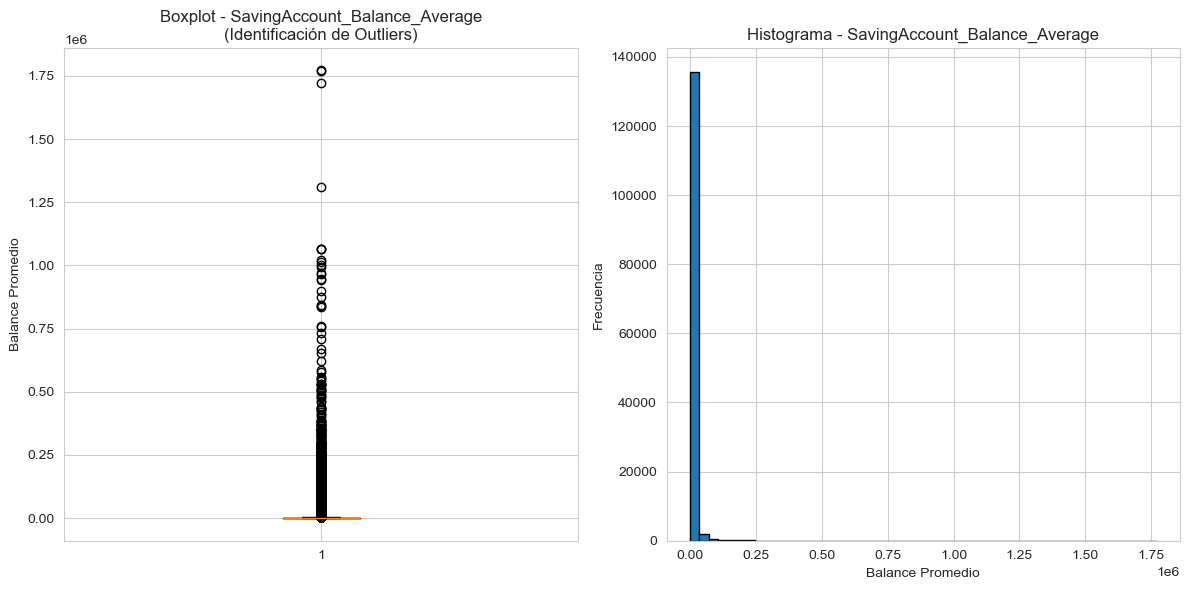


Q1 (25%): 0.00
Q3 (75%): 1473.14
IQR: 1473.14
Límite inferior: -2209.71
Límite superior: 3682.84

Cantidad de outliers: 21621 (15.54%)


In [223]:
# Boxplot para visualizar outliers
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.boxplot(data_trainWindow['SavingAccount_Balance_Average'].dropna())
plt.title('Boxplot - SavingAccount_Balance_Average\n(Identificación de Outliers)')
plt.ylabel('Balance Promedio')

# Histograma para ver la distribución
plt.subplot(1, 2, 2)
plt.hist(data_trainWindow['SavingAccount_Balance_Average'].dropna(), bins=50, edgecolor='black')
plt.title('Histograma - SavingAccount_Balance_Average')
plt.xlabel('Balance Promedio')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

# Calcular percentiles para identificar outliers
q1 = data_trainWindow['SavingAccount_Balance_Average'].quantile(0.25)
q3 = data_trainWindow['SavingAccount_Balance_Average'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers_count = ((data_trainWindow['SavingAccount_Balance_Average'] < lower_bound) | 
                  (data_trainWindow['SavingAccount_Balance_Average'] > upper_bound)).sum()

print(f'\nQ1 (25%): {q1:.2f}')
print(f'Q3 (75%): {q3:.2f}')
print(f'IQR: {iqr:.2f}')
print(f'Límite inferior: {lower_bound:.2f}')
print(f'Límite superior: {upper_bound:.2f}')
print(f'\nCantidad de outliers: {outliers_count} ({outliers_count/len(data_trainWindow)*100:.2f}%)')

In [224]:
# Tratamiento de outliers para SavingAccount_Balance_Average
# Aplicamos winsorización al 1% en cada extremo (menos restrictivo)

percentile_1 = data_trainWindow['SavingAccount_Balance_Average'].quantile(0.01)
percentile_99 = data_trainWindow['SavingAccount_Balance_Average'].quantile(0.99)

data_trainWindow['SavingAccount_Balance_Average_clean'] = data_trainWindow['SavingAccount_Balance_Average'].clip(
    lower=percentile_1, 
    upper=percentile_99
)

print(f'Percentil 1%: {percentile_1:.2f}')
print(f'Percentil 99%: {percentile_99:.2f}')
print(f'\nValores ajustados: {(data_trainWindow["SavingAccount_Balance_Average"] != data_trainWindow["SavingAccount_Balance_Average_clean"]).sum()}')

Percentil 1%: 0.00
Percentil 99%: 70055.68

Valores ajustados: 1616


## Caso de Uso 10: Aplicar análisis de outliers a otra feature



**Resolución:** Aplicamos el mismo análisis de outliers a CreditCard_Total_Spending, probando diferentes métodos.

In [225]:
# Análisis de CreditCard_Total_Spending
print('Estadísticas descriptivas - CreditCard_Total_Spending:')
print(data_trainWindow['CreditCard_Total_Spending'].describe())

# Calcular skewness
skewness_cc = data_trainWindow['CreditCard_Total_Spending'].skew()
print(f'\nSkewness: {skewness_cc:.2f}')

if skewness_cc > 0.5:
    print('Distribución: POSITIVE SKEW (valores altos atípicos)')
elif skewness_cc < -0.5:
    print('Distribución: NEGATIVE SKEW (valores bajos atípicos)')
else:
    print('Distribución: SYMMETRICAL')

Estadísticas descriptivas - CreditCard_Total_Spending:
count    139146.00000
mean       4226.44988
std        7290.00507
min      -30164.77000
25%           0.00000
50%        1482.71000
75%        5656.14750
max      176554.25000
Name: CreditCard_Total_Spending, dtype: float64

Skewness: 4.46
Distribución: POSITIVE SKEW (valores altos atípicos)


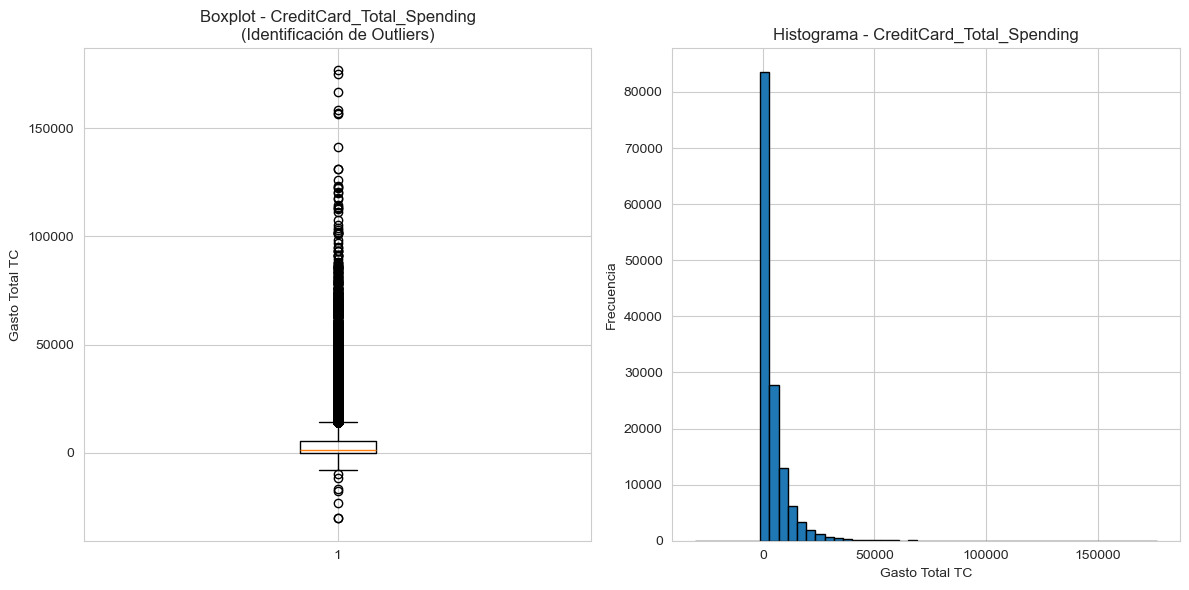

In [226]:
# Boxplot para CreditCard_Total_Spending
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.boxplot(data_trainWindow['CreditCard_Total_Spending'].dropna())
plt.title('Boxplot - CreditCard_Total_Spending\n(Identificación de Outliers)')
plt.ylabel('Gasto Total TC')

plt.subplot(1, 2, 2)
plt.hist(data_trainWindow['CreditCard_Total_Spending'].dropna(), bins=50, edgecolor='black')
plt.title('Histograma - CreditCard_Total_Spending')
plt.xlabel('Gasto Total TC')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

In [227]:
# Comparación de 3 métodos de tratamiento de outliers

# MÉTODO 1: Percentil 1% y 99% (menos restrictivo)
p1 = data_trainWindow['CreditCard_Total_Spending'].quantile(0.01)
p99 = data_trainWindow['CreditCard_Total_Spending'].quantile(0.99)
data_trainWindow['CC_Spending_Method1'] = data_trainWindow['CreditCard_Total_Spending'].clip(p1, p99)

# MÉTODO 2: Percentil 5% y 95% (más restrictivo)
p5 = data_trainWindow['CreditCard_Total_Spending'].quantile(0.05)
p95 = data_trainWindow['CreditCard_Total_Spending'].quantile(0.95)
data_trainWindow['CC_Spending_Method2'] = data_trainWindow['CreditCard_Total_Spending'].clip(p5, p95)

# MÉTODO 3: 3 desviaciones estándar (3*sigma)
mean_cc = data_trainWindow['CreditCard_Total_Spending'].mean()
std_cc = data_trainWindow['CreditCard_Total_Spending'].std()
lower_3sigma = mean_cc - 3*std_cc
upper_3sigma = mean_cc + 3*std_cc
data_trainWindow['CC_Spending_Method3'] = data_trainWindow['CreditCard_Total_Spending'].clip(lower_3sigma, upper_3sigma)

print('MÉTODO 1 - Percentil 1% y 99%:')
print(f'Límites: [{p1:.2f}, {p99:.2f}]')
print(f'Valores ajustados: {(data_trainWindow["CreditCard_Total_Spending"] != data_trainWindow["CC_Spending_Method1"]).sum()}\n')

print('MÉTODO 2 - Percentil 5% y 95%:')
print(f'Límites: [{p5:.2f}, {p95:.2f}]')
print(f'Valores ajustados: {(data_trainWindow["CreditCard_Total_Spending"] != data_trainWindow["CC_Spending_Method2"]).sum()}\n')

print('MÉTODO 3 - 3 Sigma:')
print(f'Media: {mean_cc:.2f}, Std: {std_cc:.2f}')
print(f'Límites: [{max(0, lower_3sigma):.2f}, {upper_3sigma:.2f}]')
print(f'Valores ajustados: {(data_trainWindow["CreditCard_Total_Spending"] != data_trainWindow["CC_Spending_Method3"]).sum()}')

print('\nCONCLUSIÓN: Elegimos el Método 1 (1%-99%) por ser menos agresivo y preservar más información')

MÉTODO 1 - Percentil 1% y 99%:
Límites: [0.00, 33148.24]
Valores ajustados: 1454

MÉTODO 2 - Percentil 5% y 95%:
Límites: [0.00, 17131.67]
Valores ajustados: 7020

MÉTODO 3 - 3 Sigma:
Media: 4226.45, Std: 7290.01
Límites: [0.00, 26096.47]
Valores ajustados: 2611

CONCLUSIÓN: Elegimos el Método 1 (1%-99%) por ser menos agresivo y preservar más información


## Caso de Uso 11: Crear Aggregate Features



**Resolución:** Creamos features agregadas (max, min, avg, median, sum, variance, variación) para diferentes ventanas temporales dentro del período de entrenamiento.

In [228]:
# Definir variables numéricas para agregar

# Seleccionamos las más relevantes para el negocio



vars_to_aggregate = [

    'SavingAccount_Balance_Average',

    'SavingAccount_Days_with_use',

    'SavingAccount_Transactions_Transactions',

    'SavingAccount_Total_Amount',

    'SavingAccount_Credits_Amounts',

    'SavingAccount_Debits_Amounts',

    'CreditCard_Total_Spending',

    'CreditCard_Balance_ARG',

    'Operation_total',

    'Operation_digitales',

    'Operation_digitales_porc',

    'CreditCard_Utilization_ARG_Ratio',
    'CreditCard_AutoPayment_Ratio',

    'Total_Products_Active'

]



print(f'Variables a agregar: {len(vars_to_aggregate)}')

print(vars_to_aggregate)

Variables a agregar: 14
['SavingAccount_Balance_Average', 'SavingAccount_Days_with_use', 'SavingAccount_Transactions_Transactions', 'SavingAccount_Total_Amount', 'SavingAccount_Credits_Amounts', 'SavingAccount_Debits_Amounts', 'CreditCard_Total_Spending', 'CreditCard_Balance_ARG', 'Operation_total', 'Operation_digitales', 'Operation_digitales_porc', 'CreditCard_Utilization_ARG_Ratio', 'CreditCard_AutoPayment_Ratio', 'Total_Products_Active']


In [229]:
# AGREGACIÓN 1: Todos los meses de la ventana de entrenamiento (6 meses)
# Funciones de agregación: sum, max, min, mean, median, std (varianza)

agg_functions = ['sum', 'max', 'min', 'mean', 'median', 'std']

data_agg_all = data_trainWindow.groupby('client_id')[vars_to_aggregate].agg(agg_functions)

# Renombrar columnas para claridad
data_agg_all.columns = ['_'.join(col).strip() + '_6m' for col in data_agg_all.columns.values]
data_agg_all = data_agg_all.reset_index()

print(f'Aggregate Features creadas (6 meses): {len(data_agg_all.columns) - 1}')
print(f'Ejemplos: {list(data_agg_all.columns[:5])}')

Aggregate Features creadas (6 meses): 84
Ejemplos: ['client_id', 'SavingAccount_Balance_Average_sum_6m', 'SavingAccount_Balance_Average_max_6m', 'SavingAccount_Balance_Average_min_6m', 'SavingAccount_Balance_Average_mean_6m']


In [230]:
# AGREGACIÓN 2: Últimos 3 meses (noviembre, diciembre, enero)

data_last3m = data_trainWindow[data_trainWindow['Month'].isin(['2018-11-01', '2018-12-01', '2019-01-01'])]

data_agg_3m = data_last3m.groupby('client_id')[vars_to_aggregate].agg(agg_functions)
data_agg_3m.columns = ['_'.join(col).strip() + '_3m' for col in data_agg_3m.columns.values]
data_agg_3m = data_agg_3m.reset_index()

print(f'Aggregate Features creadas (3 meses): {len(data_agg_3m.columns) - 1}')

Aggregate Features creadas (3 meses): 84


In [231]:
# AGREGACIÓN 3: Primeros 3 meses (agosto, septiembre, octubre)

data_first3m = data_trainWindow[data_trainWindow['Month'].isin(['2018-08-01', '2018-09-01', '2018-10-01'])]

data_agg_first3m = data_first3m.groupby('client_id')[vars_to_aggregate].agg(agg_functions)
data_agg_first3m.columns = ['_'.join(col).strip() + '_first3m' for col in data_agg_first3m.columns.values]
data_agg_first3m = data_agg_first3m.reset_index()

print(f'Aggregate Features creadas (primeros 3 meses): {len(data_agg_first3m.columns) - 1}')

Aggregate Features creadas (primeros 3 meses): 84


In [232]:
# AGREGACIÓN 4: Variación entre primer y último mes
# Calculamos la diferencia para identificar tendencias

data_first_month = data_trainWindow[data_trainWindow['Month'] == '2018-08-01'][['client_id'] + vars_to_aggregate]
data_last_month = data_trainWindow[data_trainWindow['Month'] == '2019-01-01'][['client_id'] + vars_to_aggregate]

# Merge y calcular diferencia
data_variation = data_last_month.merge(data_first_month, on='client_id', suffixes=('_last', '_first'))

for var in vars_to_aggregate:
    data_variation[f'{var}_variation'] = data_variation[f'{var}_last'] - data_variation[f'{var}_first']

# Seleccionar solo las columnas de variación
variation_cols = ['client_id'] + [f'{var}_variation' for var in vars_to_aggregate]
data_variation = data_variation[variation_cols]

print(f'Variación Features creadas: {len(variation_cols) - 1}')
print(f'Ejemplos: {variation_cols[:5]}')

Variación Features creadas: 14
Ejemplos: ['client_id', 'SavingAccount_Balance_Average_variation', 'SavingAccount_Days_with_use_variation', 'SavingAccount_Transactions_Transactions_variation', 'SavingAccount_Total_Amount_variation']


In [233]:
# AGREGACIÓN 5: Contar meses con valores no cero (indica actividad)

def count_nonzero(x):
    return (x != 0).sum()

data_nonzero = data_trainWindow.groupby('client_id')[vars_to_aggregate].agg(count_nonzero)
data_nonzero.columns = [f'{col}_nonzero_months' for col in data_nonzero.columns]
data_nonzero = data_nonzero.reset_index()

print(f'Non-Zero Count Features creadas: {len(data_nonzero.columns) - 1}')

Non-Zero Count Features creadas: 14


## Caso de Uso 12: Crear Analytic Base Table (ABT)



**Resolución:** Unimos todas las features creadas:

- **Identity Features:** Características del cliente del último mes

- **Transform Features:** Variables derivadas/calculadas 

- **Aggregate Features:** Agregaciones temporales

- **Label:** Target a predecir (TGT)

In [234]:
# Unir todas las tablas de features
# Comenzamos con data_final que tiene client_id y TGT

print('Creando Analytic Base Table...')
print(f'\nBase inicial (client_id + TGT): {data_final.shape}')

# 1. Agregar Identity Features
abt = data_final.merge(data_if, on='client_id', how='left')
print(f'Después de Identity Features: {abt.shape}')

# 2. Agregar Aggregate Features - 6 meses
abt = abt.merge(data_agg_all, on='client_id', how='left')
print(f'Después de Aggregates 6m: {abt.shape}')

# 3. Agregar Aggregate Features - últimos 3 meses
abt = abt.merge(data_agg_3m, on='client_id', how='left')
print(f'Después de Aggregates 3m: {abt.shape}')

# 4. Agregar Aggregate Features - primeros 3 meses
abt = abt.merge(data_agg_first3m, on='client_id', how='left')
print(f'Después de Aggregates first 3m: {abt.shape}')

# 5. Agregar Variation Features
abt = abt.merge(data_variation, on='client_id', how='left')
print(f'Después de Variation Features: {abt.shape}')

# 6. Agregar Non-Zero Count Features
abt = abt.merge(data_nonzero, on='client_id', how='left')
print(f'Después de Non-Zero Features: {abt.shape}')

# Rellenar NaN con 0 en features numéricas
numeric_cols = abt.select_dtypes(include=[np.number]).columns
abt[numeric_cols] = abt[numeric_cols].fillna(0)

print(f'\nANALYTIC BASE TABLE FINAL: {abt.shape}')
print(f'Clientes: {abt.shape[0]} | Features: {abt.shape[1] - 2}')  # -2 por client_id y TGT

Creando Analytic Base Table...

Base inicial (client_id + TGT): (23191, 2)
Después de Identity Features: (23191, 25)
Después de Aggregates 6m: (23191, 109)
Después de Aggregates 3m: (23191, 193)
Después de Aggregates first 3m: (23191, 277)
Después de Variation Features: (23191, 291)
Después de Non-Zero Features: (23191, 305)

ANALYTIC BASE TABLE FINAL: (23191, 305)
Clientes: 23191 | Features: 303


In [235]:
# VERIFICACIÓN CRÍTICA: Confirmar que llegamos a 23191 registros

print('='*60)
print('VERIFICACIÓN DE FILTROS APLICADOS')
print('='*60)

print(f'\nNúmero final de clientes: {len(abt)}')

if len(abt) == 23191:
    print('\n✓ CORRECTO: Se alcanzó el objetivo de 23191 clientes')
    print('\nFiltros aplicados exitosamente:')
    print('1. Clientes con exactamente 9 meses de datos')
    print('2. Clientes sin Package_Active en enero 2019')
    print('3. Clientes sin CreditCard_CoBranding en enero 2019')
else:
    print(f'\n✗ ATENCIÓN: Se esperaban 23191 clientes, se obtuvieron {len(abt)}')

print(f'\nDistribución del Target:')
print(abt['TGT'].value_counts())
print(f'\nPorcentaje de Target=1: {abt["TGT"].mean()*100:.2f}%')

VERIFICACIÓN DE FILTROS APLICADOS

Número final de clientes: 23191

✓ CORRECTO: Se alcanzó el objetivo de 23191 clientes

Filtros aplicados exitosamente:
1. Clientes con exactamente 9 meses de datos
2. Clientes sin Package_Active en enero 2019
3. Clientes sin CreditCard_CoBranding en enero 2019

Distribución del Target:
TGT
0.0    16368
1.0     6823
Name: count, dtype: int64

Porcentaje de Target=1: 29.42%


In [236]:
# Resumen de la Analytic Base Table

print('RESUMEN DE LA ANALYTIC BASE TABLE')
print('='*60)

print(f'\n1. DIMENSIONES:')
print(f'   - Registros (clientes): {abt.shape[0]}')
print(f'   - Features totales: {abt.shape[1]}')

print(f'\n2. COMPOSICIÓN:')
identity_count = len([col for col in abt.columns if col in identity_features])
aggregate_count = len([col for col in abt.columns if any(x in col for x in ['_6m', '_3m', '_first3m', '_variation', '_nonzero'])])
print(f'   - Identity Features: {identity_count}')
print(f'   - Aggregate Features: {aggregate_count}')
print(f'   - Target (TGT): 1')

print(f'\n3. TARGET:')
print(f'   - Clientes con TGT=0: {(abt["TGT"]==0).sum()}')
print(f'   - Clientes con TGT=1: {(abt["TGT"]==1).sum()}')
print(f'   - Tasa de conversión: {abt["TGT"].mean()*100:.2f}%')

print(f'\n4. CALIDAD DE DATOS:')
print(f'   - Valores nulos totales: {abt.isnull().sum().sum()}')
print(f'   - Columnas con nulos: {abt.columns[abt.isnull().any()].tolist()}')

RESUMEN DE LA ANALYTIC BASE TABLE

1. DIMENSIONES:
   - Registros (clientes): 23191
   - Features totales: 305

2. COMPOSICIÓN:
   - Identity Features: 24
   - Aggregate Features: 280
   - Target (TGT): 1

3. TARGET:
   - Clientes con TGT=0: 16368
   - Clientes con TGT=1: 6823
   - Tasa de conversión: 29.42%

4. CALIDAD DE DATOS:
   - Valores nulos totales: 46382
   - Columnas con nulos: ['Region', 'CreditCard_Product']


In [237]:
# Mostrar muestra de la tabla final
print('Muestra de la Analytic Base Table:')
abt.head(10)

Muestra de la Analytic Base Table:


,client_id,TGT,CreditCard_Premium,CreditCard_Active,CreditCard_CoBranding,Loan_Active,Mortgage_Active,SavingAccount_Active_ARG_Salary,SavingAccount_Active_ARG,SavingAccount_Active_DOLLAR,DebitCard_Active,Investment_Active,Package_Active,Insurance_Life,Insurance_Home,Insurance_Accidents,Insurance_Mobile,Insurance_ATM,Insurance_Unemployment,Sex,Client_Age_grp,Mobile,Email,Region,CreditCard_Product,SavingAccount_Balance_Average_sum_6m,SavingAccount_Balance_Average_max_6m,SavingAccount_Balance_Average_min_6m,SavingAccount_Balance_Average_mean_6m,SavingAccount_Balance_Average_median_6m,SavingAccount_Balance_Average_std_6m,SavingAccount_Days_with_use_sum_6m,SavingAccount_Days_with_use_max_6m,SavingAccount_Days_with_use_min_6m,SavingAccount_Days_with_use_mean_6m,SavingAccount_Days_with_use_median_6m,SavingAccount_Days_with_use_std_6m,SavingAccount_Transactions_Transactions_sum_6m,SavingAccount_Transactions_Transactions_max_6m,SavingAccount_Transactions_Transactions_min_6m,SavingAccount_Transactions_Transactions_mean_6m,SavingAccount_Transactions_Transactions_median_6m,SavingAccount_Transactions_Transactions_std_6m,SavingAccount_Total_Amount_sum_6m,SavingAccount_Total_Amount_max_6m,SavingAccount_Total_Amount_min_6m,SavingAccount_Total_Amount_mean_6m,SavingAccount_Total_Amount_median_6m,SavingAccount_Total_Amount_std_6m,SavingAccount_Credits_Amounts_sum_6m,SavingAccount_Credits_Amounts_max_6m,SavingAccount_Credits_Amounts_min_6m,SavingAccount_Credits_Amounts_mean_6m,SavingAccount_Credits_Amounts_median_6m,SavingAccount_Credits_Amounts_std_6m,SavingAccount_Debits_Amounts_sum_6m,SavingAccount_Debits_Amounts_max_6m,SavingAccount_Debits_Amounts_min_6m,SavingAccount_Debits_Amounts_mean_6m,SavingAccount_Debits_Amounts_median_6m,SavingAccount_Debits_Amounts_std_6m,CreditCard_Total_Spending_sum_6m,CreditCard_Total_Spending_max_6m,CreditCard_Total_Spending_min_6m,CreditCard_Total_Spending_mean_6m,CreditCard_Total_Spending_median_6m,CreditCard_Total_Spending_std_6m,CreditCard_Balance_ARG_sum_6m,CreditCard_Balance_ARG_max_6m,CreditCard_Balance_ARG_min_6m,CreditCard_Balance_ARG_mean_6m,CreditCard_Balance_ARG_median_6m,CreditCard_Balance_ARG_std_6m,Operation_total_sum_6m,Operation_total_max_6m,Operation_total_min_6m,Operation_total_mean_6m,Operation_total_median_6m,Operation_total_std_6m,Operation_digitales_sum_6m,Operation_digitales_max_6m,Operation_digitales_min_6m,Operation_digitales_mean_6m,Operation_digitales_median_6m,Operation_digitales_std_6m,Operation_digitales_porc_sum_6m,Operation_digitales_porc_max_6m,Operation_digitales_porc_min_6m,Operation_digitales_porc_mean_6m,Operation_digitales_porc_median_6m,Operation_digitales_porc_std_6m,CreditCard_Utilization_ARG_Ratio_sum_6m,CreditCard_Utilization_ARG_Ratio_max_6m,CreditCard_Utilization_ARG_Ratio_min_6m,CreditCard_Utilization_ARG_Ratio_mean_6m,CreditCard_Utilization_ARG_Ratio_median_6m,CreditCard_Utilization_ARG_Ratio_std_6m,CreditCard_AutoPayment_Ratio_sum_6m,CreditCard_AutoPayment_Ratio_max_6m,CreditCard_AutoPayment_Ratio_min_6m,CreditCard_AutoPayment_Ratio_mean_6m,CreditCard_AutoPayment_Ratio_median_6m,CreditCard_AutoPayment_Ratio_std_6m,Total_Products_Active_sum_6m,Total_Products_Active_max_6m,Total_Products_Active_min_6m,Total_Products_Active_mean_6m,Total_Products_Active_median_6m,Total_Products_Active_std_6m,SavingAccount_Balance_Average_sum_3m,SavingAccount_Balance_Average_max_3m,SavingAccount_Balance_Average_min_3m,SavingAccount_Balance_Average_mean_3m,SavingAccount_Balance_Average_median_3m,SavingAccount_Balance_Average_std_3m,SavingAccount_Days_with_use_sum_3m,SavingAccount_Days_with_use_max_3m,SavingAccount_Days_with_use_min_3m,SavingAccount_Days_with_use_mean_3m,SavingAccount_Days_with_use_median_3m,SavingAccount_Days_with_use_std_3m,SavingAccount_Transactions_Transactions_sum_3m,SavingAccount_Transactions_Transactions_max_3m,SavingAccount_Transactions_Transactions_min_3m,SavingAccount_Transactions_Transactions_mean_3m,SavingAccount_Transactions_Transactions_median_3m,SavingAcco

In [240]:
# Exportar la Analytic Base Table para uso futuro
abt.to_csv('analytic_base_table.csv', index=False)
print('Analytic Base Table exportada exitosamente a: analytic_base_table.csv')

Analytic Base Table exportada exitosamente a: analytic_base_table.csv
